# Populating city and cityH3Map tables

This notebook populates DB tables with city boundary data. 
Bounding boxes are determined outside of this notebook based on manual comparisons of public transit network coverage and city boundaries.

In [2]:
import psycopg2
import h3
import geopandas as gpd
from shapely import geometry
import json
import h3pandas
import itertools as itt

from psycopg2.extras import execute_values

## DB setup

In [3]:
city_table_sql = """CREATE TABLE IF NOT EXISTS public.cities
(
    CityID serial NOT NULL,
    CityName varchar(50) NOT NULL,
    BoundingBox real[],
    PRIMARY KEY (CityID)
);"""


cityh3map_table_sql = """
CREATE TABLE IF NOT EXISTS public.cityh3map
(
    id serial NOT NULL,
    CityID integer NOT NULL,
    H3ID character(15) NOT NULL,    
    PRIMARY KEY ("id")
);

CREATE INDEX IF NOT EXISTS city_id_index ON public.cityh3map USING HASH (CityID);

CREATE INDEX IF NOT EXISTS city_h3_index ON public.cityh3map USING HASH (H3ID);

"""

with psycopg2.connect("dbname=main user=aurimas") as conn:
    with conn.cursor() as cur:
        cur.execute(city_table_sql)
        cur.execute(cityh3map_table_sql)

## Atlanta area

<div>
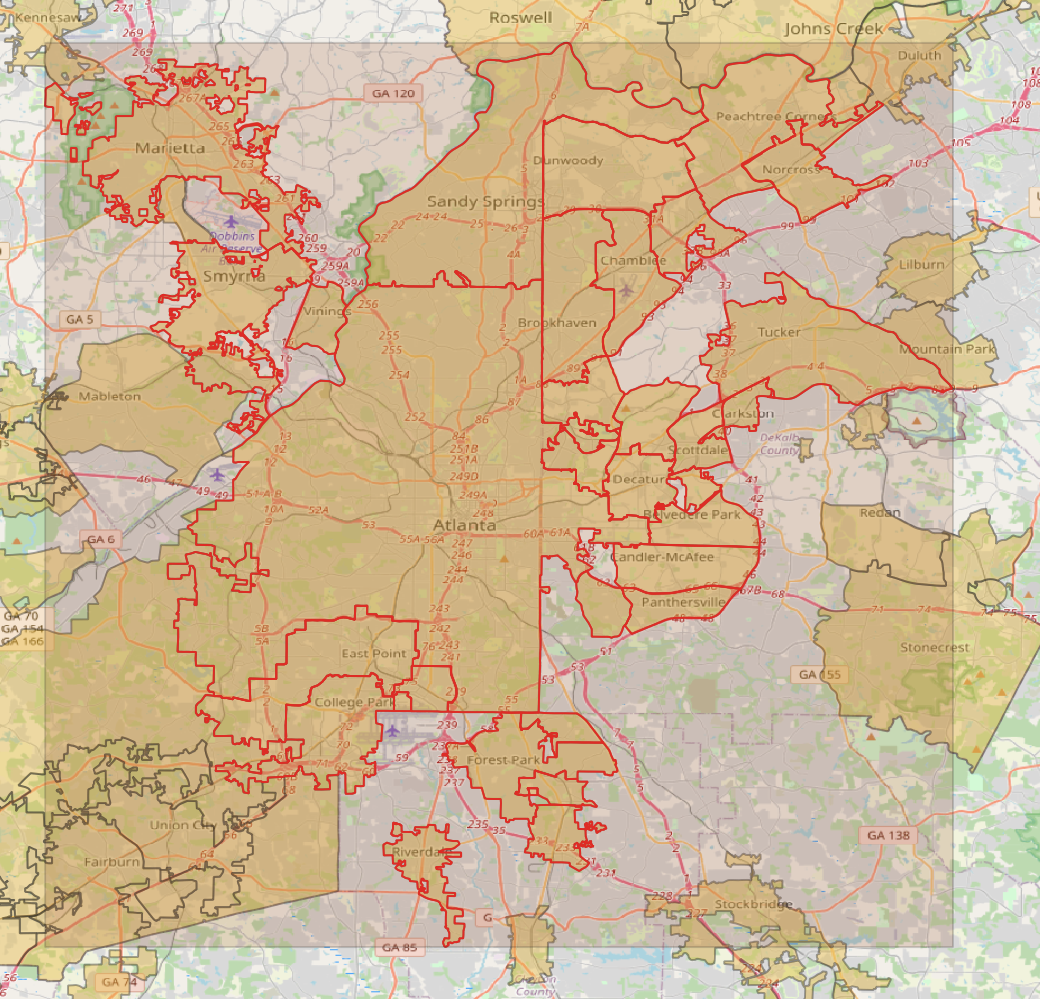
</div>


## Inserting data into DB

Using **level 9** for as the main basis hexagons

In [4]:
H3_LEVEL = 9
cities = [
    ('Atlanta', [-84.617192, 33.521005, -84.126103, 34.010137])
]

In [6]:
with psycopg2.connect("dbname=main user=aurimas") as conn:
    with conn.cursor() as cur:
        for name, bbox in cities:
            #check if the city already exists - if so, skip    
            cur.execute(""" SELECT cities.CityID FROM public.cities WHERE CityName = %s """, (name,))
            if cur.fetchone() is None:
                print(f"Inserting {name}")
                
                #add city to the city list
                cur.execute("""INSERT INTO public.cities (CityName, BoundingBox) VALUES(%s, %s) RETURNING CityID """, name)
                city_id = cur.fetchone()[0]
                
                #find all h3 polygons
                polygon = geometry.Polygon(geometry.box(*bbox))
                gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([polygon]))
                h3_inds = gdf.h3.polyfill(resolution=H3_LEVEL, explode=True).h3_polyfill.values
                print("Found {} polygons in the area".format(len(h3_inds)))
                
                #save h3 polygons to DB
                vals = zip(itt.repeat(city_id), h3_inds)
                execute_values(cur, "INSERT INTO public.cityh3map (CityID, H3ID) VALUES %s", list(vals))
            else: 
                print(f"{name} already exists - skipping")


Atlanta already exists - skipping
